## Bike Sharing -Assignment

`Problem Statement`: A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.They want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
    1) Which variables are significant in predicting the demand for shared bikes.
    2) How well those variables describe the bike demands


### Data Cleaning, Reading and Understanding of the Data

In [256]:
#surpress warnings
import warnings
warnings.filterwarnings('ignore')
#import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [257]:
#read the dataset
day = pd.read_csv('day.csv') 
day.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [258]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [259]:
#As dteday is in object datatype , so we will convert dteday column into datetime format
day.dteday = pd.to_datetime(day['dteday'])
print (day.dteday.dtypes)
print (pd.DatetimeIndex(day.dteday).year.unique())
print (pd.DatetimeIndex(day.dteday).month.unique())

datetime64[ns]
Int64Index([2018, 2019], dtype='int64', name='dteday')
Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='dteday')


from the above output, it is clear that column contain dates of only 2018 and 2019 years. we already have two columns yr and mnth, so to reduce the redundancy in data we will drop 'dteday' column

In [260]:
# check the rows where casual + registered is not equal to cnt column value
day[day.cnt!= day.casual+day.registered]

Empty DataFrame
Columns: [instant, dteday, season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt]
Index: []

According to the result, there is no records where cnt is not equal to `casual + registered`. As we are doing analysis on total cnt, so we will drop these two columns too.
In the dataset from the `instant` column we are not getting any pattern because of its uniqueness. so drop that column too

In [261]:
day = day.drop(['dteday','casual','registered','instant'], axis=1)
day.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed   cnt  
0  18.18125  80.5833  10.749882   985  
1  17.68695  69.6087  16.652113   801  
2   9.47025  43.7273  16.636703  1349  
3  10.60610  59.0435  10.739832  1562  
4  11.46350  43.6957  12.522300  1600

In [262]:
#Check sum of null records in the dataset for every column
day.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [263]:
# check for duplicates record in the dataset
day = day.drop_duplicates()
day.shape

(730, 12)

In [264]:
#to check the statistics of every numerical columns
day.describe()

season          yr        mnth     holiday     weekday  workingday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     2.498630    0.500000    6.526027    0.028767    2.997260    0.683562   
std      1.110184    0.500343    3.450215    0.167266    2.006161    0.465405   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    0.500000    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   

       weathersit        temp       atemp         hum   windspeed          cnt  
count  730.000000  730.000000  730.000000  730.000000  730.000000   730.000000  
mean     1.394521   20.319259   23.726322   62.765175   12.763620  4508.006849  
std      0.544807    7.506729    8.150308   14.237589    5.195841  1936.011647  
min      1.000000    2.424346    3.953480    0.000000    1.500244    22.000000  
25%      1.000000   13.811885   16.889713   52.000000    9.041650  3169.750000  
50%      1.000000   20.465826   24.368225   62.625000   12.125325  4548.500000  
75%      2.000000   26.880615   30.445775   72.989575   15.625589  5966.000000  
max      3.000000   35.328347   42.044800   97.250000   34.000021  8714.000000

##### Now, According to Data Dictionary, we will replace the levels present in columns ` mnth, weekday, season and weathersit` into strings 

In [265]:
#convert season column value into string 
day.season.replace((1,2,3,4),('spring','summer','fall','winter'), inplace=True)

In [266]:
#convert season column value into string 
day.season.replace((1,2,3,4),('spring','summer','fall','winter'), inplace=True)
#convert weathersit column value into string 
day.weathersit.replace((1,2,3,4),('clear','mist','light_snow','Heavy_rain'), inplace=True)
#convert weekday column value into string 
day.weekday.replace((0,1,2,3,4,5,6),('tues','wednes','thurs','fri','satur','sun','mon'), inplace=True)
#convert mnth column value into string 
day.mnth.replace((1,2,3,4,5,6,7,8,9,10,11,12),('jan','feb','mar','apr','may','jun','jul','aug','sept',\
                                               'oct','nov','dec'), inplace=True)

In [267]:
#check all the categorical columns and the percentage ratio of every levels
print (day.season.value_counts(normalize=True))
print (day.yr.value_counts(normalize=True))
print (day.mnth.value_counts(normalize=True))
print (day.holiday.value_counts(normalize=True))
print (day.weekday.value_counts(normalize=True))
print (day.workingday.value_counts(normalize=True))
print (day.weathersit.value_counts(normalize=True))

fall      0.257534
summer    0.252055
spring    0.246575
winter    0.243836
Name: season, dtype: float64
1    0.5
0    0.5
Name: yr, dtype: float64
jul     0.084932
oct     0.084932
mar     0.084932
may     0.084932
aug     0.084932
jan     0.084932
dec     0.084932
jun     0.082192
apr     0.082192
nov     0.082192
sept    0.082192
feb     0.076712
Name: mnth, dtype: float64
0    0.971233
1    0.028767
Name: holiday, dtype: float64
wednes    0.143836
tues      0.143836
mon       0.143836
satur     0.142466
sun       0.142466
thurs     0.142466
fri       0.141096
Name: weekday, dtype: float64
1    0.683562
0    0.316438
Name: workingday, dtype: float64
clear         0.634247
mist          0.336986
light_snow    0.028767
Name: weathersit, dtype: float64


### Data Visualisation

#### Visualisation for all numerical variables using pairplot

In [268]:
numerical_columns = ['temp','atemp','hum','windspeed','cnt']

<Figure size 1440x720 with 0 Axes>

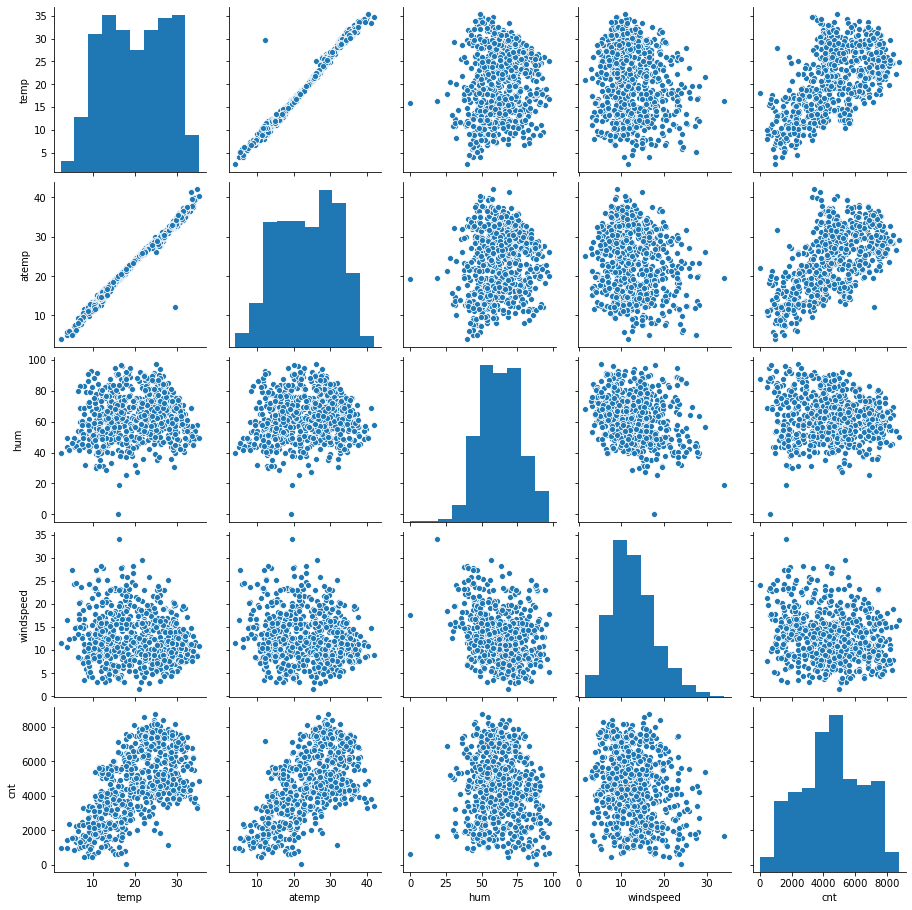

In [269]:
plt.figure(figsize=[20,10])
sns.pairplot(day[numerical_columns])
plt.show()

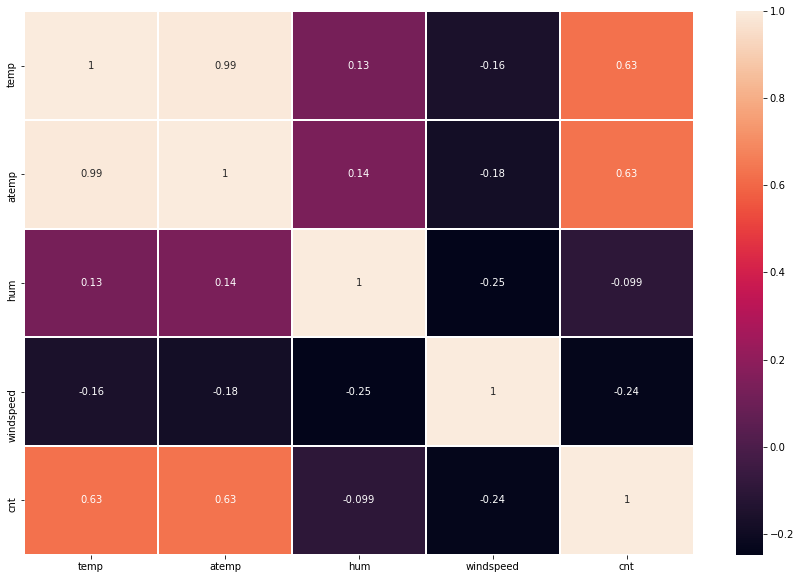

In [270]:
#To check the correlation coefficient
plt.figure(figsize=[15,10])
sns.heatmap(day[numerical_columns].corr(),annot=True, linewidth=1)
plt.show()

With `cnt` variable, correlation of temp and atemp are same(temp and atemp are highly correlated with each other). so we will drop one column between them because of multicollinearity issue

<Figure size 1080x1080 with 0 Axes>

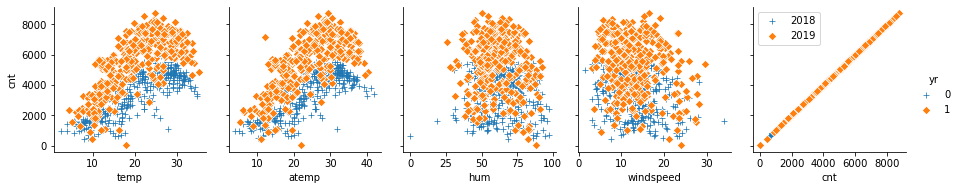

In [271]:
plt.figure(figsize=[15,15])
sns.pairplot(x_vars=numerical_columns, y_vars='cnt', hue='yr', data=day, markers=['+','D'])
plt.legend(labels=['2018','2019'])
plt.show()

Demand is more for 2019 as compare to 2018 for every numerical columns

In [272]:
#dropping column atemp from dataset (highly correlated with temp)
day.drop('atemp', axis=1, inplace=True)
day.head()

season  yr mnth  holiday weekday  workingday weathersit       temp  \
0  spring   0  jan        0     mon           0       mist  14.110847   
1  spring   0  jan        0    tues           0       mist  14.902598   
2  spring   0  jan        0  wednes           1      clear   8.050924   
3  spring   0  jan        0   thurs           1      clear   8.200000   
4  spring   0  jan        0     fri           1      clear   9.305237   

       hum  windspeed   cnt  
0  80.5833  10.749882   985  
1  69.6087  16.652113   801  
2  43.7273  16.636703  1349  
3  59.0435  10.739832  1562  
4  43.6957  12.522300  1600

In [273]:
#Create list of categorical columns 
categorical_columns =['yr','mnth','season','weathersit','weekday','holiday','workingday']

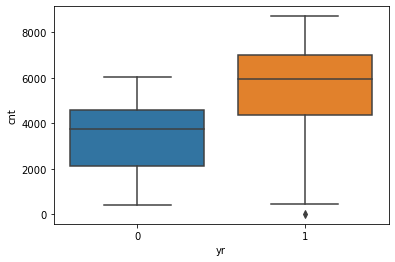

In [274]:
# Build boxplot for all the categorical variables (before creating dummies) againt the target variable 'cnt' 
# Check each of the  variables distribution with respect to the target variable.

sns.boxplot(data=day ,x= categorical_columns[0], y='cnt')
plt.show()

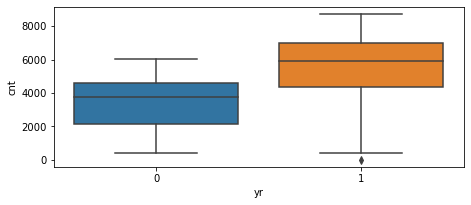

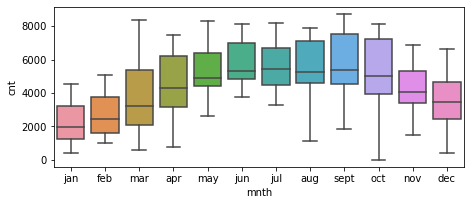

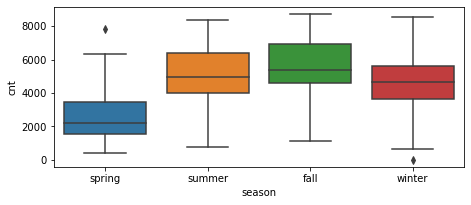

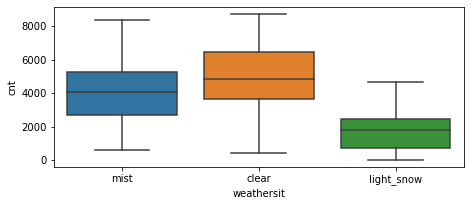

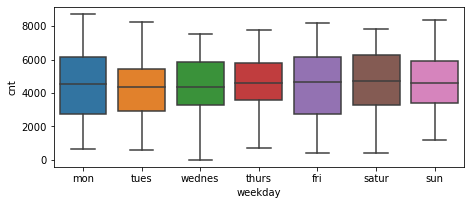

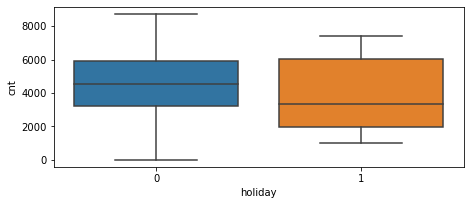

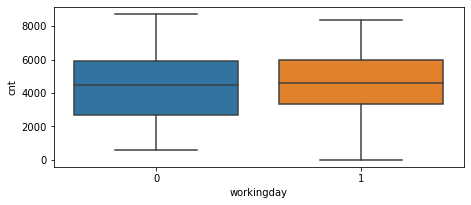

In [275]:
for col, i in zip(categorical_columns, range(1,len(categorical_columns)+1)):
    plt.figure(figsize=(25, 10))
    plt.subplot(3,3,i)
    sns.boxplot(x = col, y = 'cnt', data = day)
    plt.show()

From all the subplots between categorical variables and  cnt, we can see some pattern in all the plots. Range of Values are not same for any of the levels

In [276]:
#created function to calculate statistics of all categorical function
def cat_col_stats(col):
    df = day.groupby(col)['cnt'].agg(['mean','sum','count'])
    df['sum_percent'] = df['sum'].apply(lambda x: x/day.cnt.sum()*100)
    df['count_percent'] = df['count'].apply(lambda x: x/day.cnt.count()*100)
    print( round(df,2))

#created function to return barplot of all categorical function and barplot with hue as yr column 
def cat_col_plots(col, x, y):
    plt.figure(figsize=[x,y])
    plt.subplot(1,2,1)
    sns.barplot(x = col,y='cnt', data=day)
    plt.subplot(1,2,2)
    ax = sns.barplot(x = col,y='cnt', data=day, hue='yr')
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['2018','2019'], title='Year')
    plt.show()
    return

           mean      sum  count  sum_percent  count_percent
season                                                     
fall    5644.30  1061129    188        32.24          25.75
spring  2608.41   469514    180        14.27          24.66
summer  4992.33   918589    184        27.91          25.21
winter  4728.16   841613    178        25.57          24.38


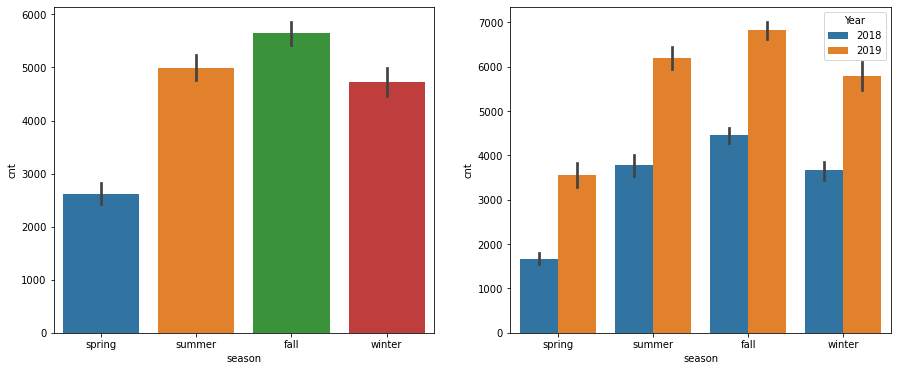

In [277]:
#visualize for sesaon column
cat_col_stats('season')
cat_col_plots('season', 15,6)

Insight1:
Above graph is following some trend so it indicates that the season can be a good predictor of the dependent variable.

               mean      sum  count  sum_percent  count_percent
weathersit                                                     
clear       4876.79  2257952    463        68.61          63.42
light_snow  1803.29    37869     21         1.15           2.88
mist        4044.81   995024    246        30.24          33.70


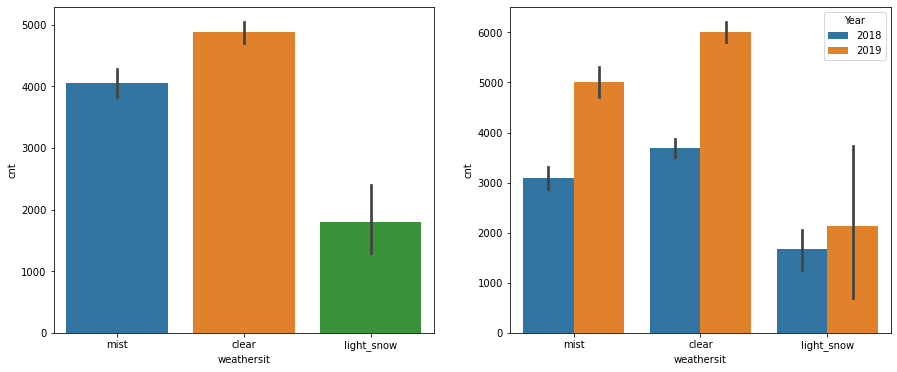

In [278]:
#visualize for weathersit column
cat_col_stats('weathersit')
cat_col_plots('weathersit', 15,6)

Insight2:
Above graph is following some pattern so it indicates that the weathersit can be a good predictor of the dependent variable.

            mean     sum  count  sum_percent  count_percent
weekday                                                    
fri      4574.89  471214    103        14.32          14.11
mon      4550.54  477807    105        14.52          14.38
satur    4667.26  485395    104        14.75          14.25
sun      4690.29  487790    104        14.82          14.25
thurs    4510.66  469109    104        14.25          14.25
tues     4228.83  444027    105        13.49          14.38
wednes   4338.12  455503    105        13.84          14.38


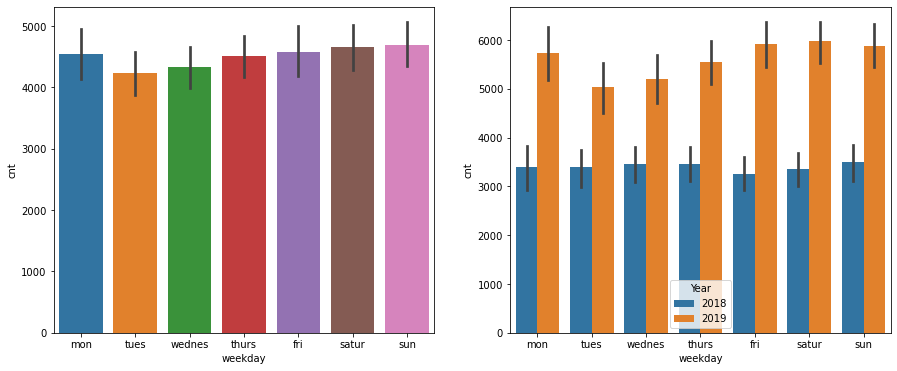

In [279]:
#visualize for weekday column
cat_col_stats('weekday')
cat_col_plots('weekday', 15,6)

Insight3:
Graph shows the very close trend between weekdays. Either this feature can be significant or not significant for the model creation.
We will not drop it as of now and do further analysis.

         mean     sum  count  sum_percent  count_percent
mnth                                                    
apr   4484.90  269094     60         8.18           8.22
aug   5664.42  351194     62        10.67           8.49
dec   3403.81  211036     62         6.41           8.49
feb   2669.96  149518     56         4.54           7.67
jan   2176.34  134933     62         4.10           8.49
jul   5563.68  344948     62        10.48           8.49
jun   5772.37  346342     60        10.52           8.22
mar   3692.26  228920     62         6.96           8.49
may   5349.77  331686     62        10.08           8.49
nov   4247.18  254831     60         7.74           8.22
oct   5199.23  322352     62         9.80           8.49
sept  5766.52  345991     60        10.51           8.22


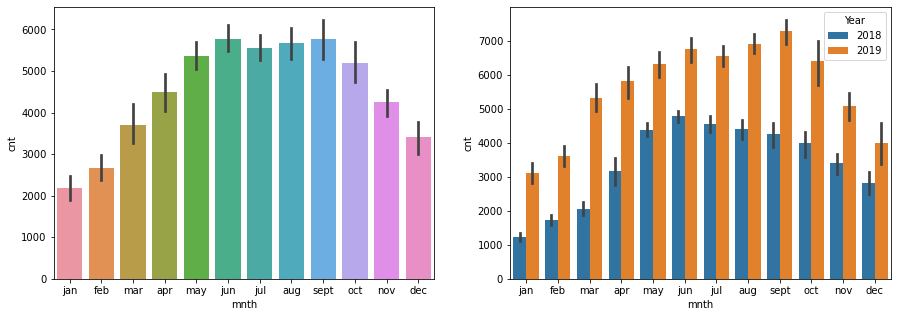

In [281]:
#visualize for mnth column
cat_col_stats('mnth')
cat_col_plots('mnth', 15,5)

Insight4:
Above graph  indicates that the mnth can be a good predictor of the dependent variable.

           mean      sum  count  sum_percent  count_percent
holiday                                                    
0        4530.9  3212410    709        97.62          97.12
1        3735.0    78435     21         2.38           2.88


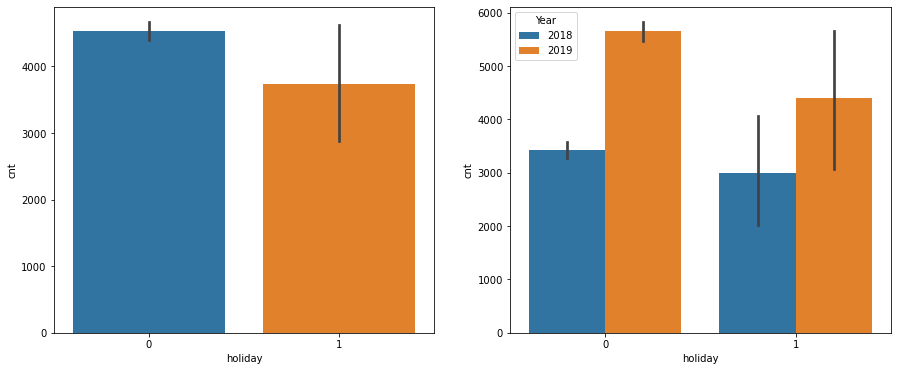

In [282]:
#visualize for holiday column
cat_col_stats('holiday')
cat_col_plots('holiday', 15,6)

Insight5: Approx 98% bike rentals occured on non - holiday

               mean      sum  count  sum_percent  count_percent
workingday                                                     
0           4330.17  1000269    231         30.4          31.64
1           4590.33  2290576    499         69.6          68.36


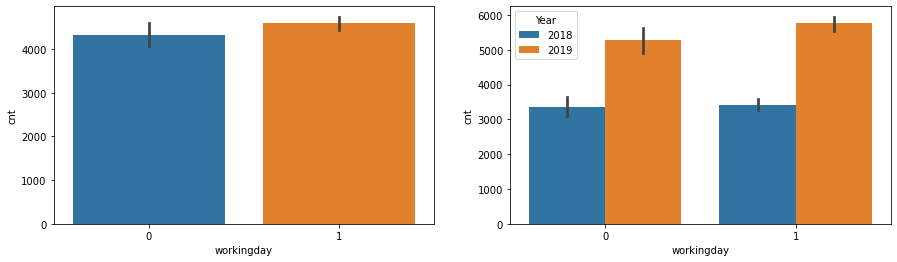

In [284]:
#visualize for workingday column
cat_col_stats('workingday')
cat_col_plots('workingday', 15,4)

Insight6: Graph represents workingday is a good predictor of the dependent variables

       mean      sum  count  sum_percent  count_percent
yr                                                     
0   3405.76  1243103    365        37.77           50.0
1   5610.25  2047742    365        62.23           50.0


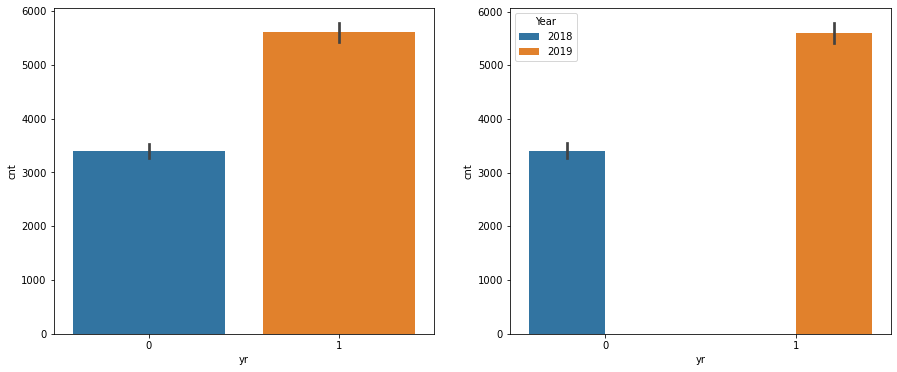

In [286]:
#visualize for yr column
cat_col_stats('yr')
cat_col_plots('yr', 15,6)

###### From the Data visualisation step, it is clear that bike trental demand increases from 2018 to 2019 .(For both the categorical and numerical columns, demand increases as year increases. so here `yr` would be our key parameter)

## Data Preparation and Splitting

#### Dummy variable creation for every categorical columns

In [287]:
## Get the dummy variables for the feature 'season' and store it in a new dataframe - 'season' and drop the first level
season = pd.get_dummies(day['season'],drop_first=True)
season.head()

spring  summer  winter
0       1       0       0
1       1       0       0
2       1       0       0
3       1       0       0
4       1       0       0

In [288]:
## Get the dummy variables for the feature 'weathersit' and store it in a new dataframe - 'weathersit' and drop the first level
weathersit = pd.get_dummies(day['weathersit'],drop_first=True)
weathersit.head()

light_snow  mist
0           0     1
1           0     1
2           0     0
3           0     0
4           0     0

In [289]:
## Get the dummy variables for the feature 'weekday' and store it in a new dataframe - 'weekday' and drop the first level
weekday = pd.get_dummies(day['weekday'],drop_first=True)
weekday.head()

mon  satur  sun  thurs  tues  wednes
0    1      0    0      0     0       0
1    0      0    0      0     1       0
2    0      0    0      0     0       1
3    0      0    0      1     0       0
4    0      0    0      0     0       0

In [290]:
## Get the dummy variables for the feature 'mnth' and store it in a new dataframe - 'mnth' and drop the first level
mnth = pd.get_dummies(day['mnth'],drop_first=True)
mnth.head()

aug  dec  feb  jan  jul  jun  mar  may  nov  oct  sept
0    0    0    0    1    0    0    0    0    0    0     0
1    0    0    0    1    0    0    0    0    0    0     0
2    0    0    0    1    0    0    0    0    0    0     0
3    0    0    0    1    0    0    0    0    0    0     0
4    0    0    0    1    0    0    0    0    0    0     0

In [291]:
#now concat all the above created dataframe to the 'day' dataframe and created new dataframe
bike = pd.concat([day,mnth,weekday,weathersit,season], axis=1)

In [292]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
 11  aug         730 non-null    uint8  
 12  dec         730 non-null    uint8  
 13  feb         730 non-null    uint8  
 14  jan         730 non-null    uint8  
 15  jul         730 non-null    uint8  
 16  jun         730 non-null    uint8  
 17  mar         730 non-null    uint8  
 18  may         730 non-null    uint8  
 19  nov         730 non-null    u

In [293]:
#Now, the columns season ,weathersit, mnth and weekday are of object data types and we dont require it so drop it
bike = bike.drop(['season','weathersit','weekday','mnth'],axis=1)
bike.head()

yr  holiday  workingday       temp      hum  windspeed   cnt  aug  dec  \
0   0        0           0  14.110847  80.5833  10.749882   985    0    0   
1   0        0           0  14.902598  69.6087  16.652113   801    0    0   
2   0        0           1   8.050924  43.7273  16.636703  1349    0    0   
3   0        0           1   8.200000  59.0435  10.739832  1562    0    0   
4   0        0           1   9.305237  43.6957  12.522300  1600    0    0   

   feb  ...  satur  sun  thurs  tues  wednes  light_snow  mist  spring  \
0    0  ...      0    0      0     0       0           0     1       1   
1    0  ...      0    0      0     1       0           0     1       1   
2    0  ...      0    0      0     0       1           0     0       1   
3    0  ...      0    0      1     0       0           0     0       1   
4    0  ...      0    0      0     0       0           0     0       1   

   summer  winter  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 29 columns]

#### Train-Test split of the dataset using sklearn module

In [294]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(bike, train_size = 0.7, random_state = 100)

In [295]:
print (df_train.shape)
print (df_test.shape)
print (df_train.head())

(510, 29)
(220, 29)
     yr  holiday  workingday       temp      hum  windspeed   cnt  aug  dec  \
576   1        0           1  29.246653  70.4167  11.083475  7216    0    0   
426   1        0           0  16.980847  62.1250  10.792293  4066    0    0   
728   1        0           0  10.489153  48.3333  23.500518  1796    0    1   
482   1        0           0  15.443347  48.9583   8.708325  4220    0    0   
111   0        0           1  13.803347  72.9583  14.707907  1683    0    0   

     feb  ...  satur  sun  thurs  tues  wednes  light_snow  mist  spring  \
576    0  ...      0    0      1     0       0           0     0       0   
426    0  ...      0    0      0     0       0           0     1       1   
728    0  ...      0    0      0     1       0           0     0       1   
482    0  ...      0    0      0     0       0           0     1       0   
111    0  ...      0    1      0     0       0           0     1       0   

     summer  winter  
576       0       0  
426 

#### In the dataset, we will scale the values of every column using MinMaxScaler (Range will be between 0 to 1)

In [296]:
# variable required to scale are given belows( which lie not between 0 and 1):
scaling_variables =['temp','hum','windspeed','cnt']

In [297]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[scaling_variables] = scaler.fit_transform(df_train[scaling_variables])

In [298]:
df_train.describe()

yr     holiday  workingday        temp         hum   windspeed  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.507843    0.025490    0.676471    0.537440    0.650480    0.320883   
std      0.500429    0.157763    0.468282    0.225858    0.145846    0.169803   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.339853    0.538643    0.199179   
50%      1.000000    0.000000    1.000000    0.542596    0.653714    0.296763   
75%      1.000000    0.000000    1.000000    0.735215    0.754830    0.414447   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              cnt         aug         dec         feb  ...       satur  \
count  510.000000  510.000000  510.000000  510.000000  ...  510.000000   
mean     0.513499    0.096078    0.084314    0.066667  ...    0.133333   
std      0.224421    0.294988    0.278131    0.249689  ...    0.340268   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.356420    0.000000    0.000000    0.000000  ...    0.000000   
50%      0.518638    0.000000    0.000000    0.000000  ...    0.000000   
75%      0.684710    0.000000    0.000000    0.000000  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

              sun       thurs        tues      wednes  light_snow        mist  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.127451    0.131373    0.143137    0.150980    0.029412    0.345098   
std      0.333805    0.338139    0.350557    0.358381    0.169124    0.475867   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           spring      summer      winter  
count  510.000000  510.000000  510.000000  
mean     0.243137    0.247059    0.247059  
std      0.429398    0.431725    0.431725  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000  

[8 rows x 29 columns]

It is clear that training data are scaled properly between 0 and 1

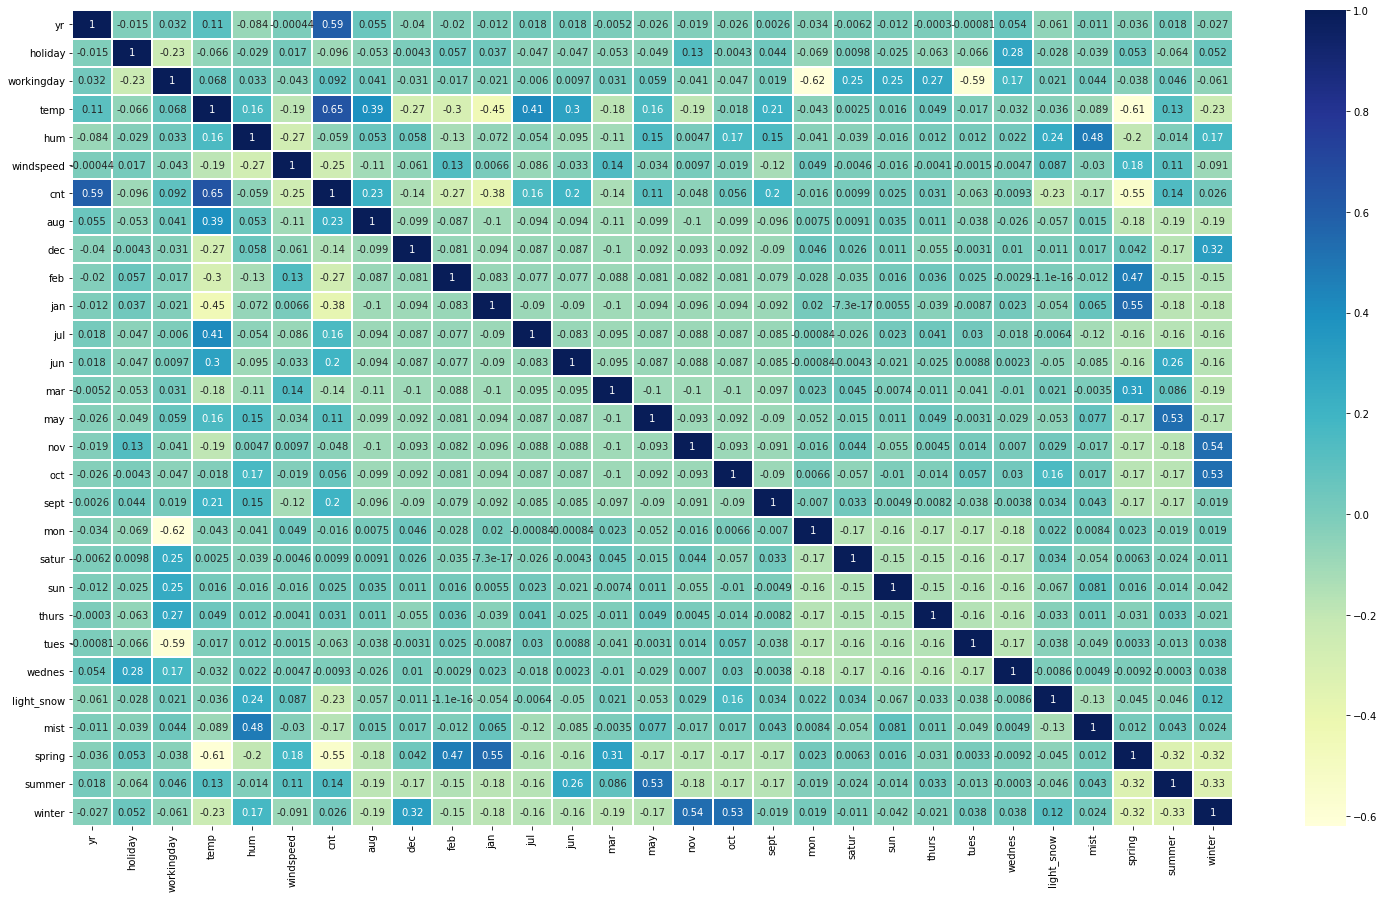

In [299]:
#Check the Correlation coefficient of every columns 
plt.figure(figsize = (26, 15))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu", linewidth=1)
plt.show()

#### Dividing df_train into independent and dependent variables

In [300]:
y_train =  df_train.pop('cnt')
x_train=   df_train

#### Build the linear regression model and Use RFE for automate feature selection

In [301]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)

# feature selection using sklearn RFE
rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(x_train, y_train)

In [302]:
list(zip(x_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('aug', False, 6),
 ('dec', False, 3),
 ('feb', False, 4),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 12),
 ('mar', False, 14),
 ('may', False, 5),
 ('nov', False, 2),
 ('oct', False, 11),
 ('sept', True, 1),
 ('mon', True, 1),
 ('satur', False, 13),
 ('sun', False, 10),
 ('thurs', False, 9),
 ('tues', False, 7),
 ('wednes', False, 8),
 ('light_snow', True, 1),
 ('mist', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1)]

In [303]:
col = x_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'jan', 'jul',
       'sept', 'mon', 'light_snow', 'mist', 'spring', 'summer', 'winter'],
      dtype='object')

These are the list of all columns which are more prioritized for model through RFE feature selection

In [304]:
x_train.columns[~rfe.support_]

Index(['aug', 'dec', 'feb', 'jun', 'mar', 'may', 'nov', 'oct', 'satur', 'sun',
       'thurs', 'tues', 'wednes'],
      dtype='object')

In [305]:
### Creating X_train dataframe with RFE selected variables
x_train_rfe = x_train[col]

#### Manual Model Development using statsmodel

In [306]:
#created a function to calculate VIF of every features for every model
def calculateVIF(df):
    vif = pd.DataFrame()
    x = df
    vif['Features'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif
# This function return the dataframe with feature name and their respective VIFs

###### Model 1:

In [307]:
import statsmodels.api as sm  

# Adding a constant variable
x_train_cnst1 = sm.add_constant(x_train_rfe)
lm1 = sm.OLS(y_train,x_train_cnst).fit()  ### First Fitted model
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          4.22e-191
Time:                        15:39:42   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2519      0.036      6.969      0.000       0.181       0.323
yr             0.2305      0.008     28.795      0.000       0.215       0.246
holiday       -0.0582      0.027     -2.164      0.031      -0.111      -0.005
workingday     0.0433      0.012      3.762      0.000       0.021       0.066
temp           0.5096      0.034     14.837      0.000       0.442       0.577
hum           -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed     -0.1863      0.025     -7.310      0.000      -0.236      -0.136
jan           -0.0345      0.017     -1.989      0.047      -0.069      -0.000
jul           -0.0529      0.018     -2.931      0.004      -0.088      -0.017
sept           0.0814      0.016      4.945      0.000       0.049       0.114
mon            0.0536      0.014      3.694      0.000       0.025       0.082
light_snow    -0.2475      0.026     -9.507      0.000      -0.299      -0.196
mist          -0.0563      0.010     -5.439      0.000      -0.077      -0.036
spring        -0.0509      0.021     -2.464      0.014      -0.091      -0.010
summer         0.0508      0.015      3.423      0.001       0.022       0.080
winter         0.0933      0.017      5.403      0.000       0.059       0.127
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [308]:
#check the VIF for every features
calculateVIF(x_train_rfe)

Features    VIF
4          hum  29.37
3         temp  17.78
2   workingday   5.31
5    windspeed   4.73
12      spring   4.53
14      winter   3.46
13      summer   2.85
11        mist   2.29
0           yr   2.09
9          mon   1.98
6          jan   1.67
7          jul   1.59
8         sept   1.39
10  light_snow   1.24
1      holiday   1.18

###### From Model1, VIF of `hum` column is high, so drop that column and again repeat the model creation

###### Model 2:

In [309]:
# As VIF of hum is high, so we drop that column and calculate VIF again
x_train_rfe = x_train_rfe.drop('hum', axis=1)
calculateVIF(x_train_rfe)

Features   VIF
3         temp  7.07
2   workingday  5.24
4    windspeed  4.68
11      spring  3.07
12      summer  2.34
0           yr  2.08
13      winter  1.98
8          mon  1.97
5          jan  1.62
6          jul  1.59
10        mist  1.58
7         sept  1.35
1      holiday  1.17
9   light_snow  1.09

In [310]:
# Model 2 creation 
x_train_cnst2 = sm.add_constant(x_train_rfe)
lm2 = sm.OLS(y_train,x_train_cnst2).fit()   # Running the linear model
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          1.60e-188
Time:                        15:41:28   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1737      0.031      5.520      0.000       0.112       0.235
yr             0.2345      0.008     29.009      0.000       0.219       0.250
holiday       -0.0558      0.027     -2.042      0.042      -0.109      -0.002
workingday     0.0464      0.012      3.966      0.000       0.023       0.069
temp           0.4722      0.034     14.005      0.000       0.406       0.538
windspeed     -0.1563      0.025     -6.286      0.000      -0.205      -0.107
jan           -0.0392      0.018     -2.227      0.026      -0.074      -0.005
jul           -0.0479      0.018     -2.614      0.009      -0.084      -0.012
sept           0.0755      0.017      4.527      0.000       0.043       0.108
mon            0.0583      0.015      3.968      0.000       0.029       0.087
light_snow    -0.2908      0.024    -11.977      0.000      -0.339      -0.243
mist          -0.0813      0.009     -9.437      0.000      -0.098      -0.064
spring        -0.0599      0.021     -2.867      0.004      -0.101      -0.019
summer         0.0445      0.015      2.967      0.003       0.015       0.074
winter         0.0784      0.017      4.562      0.000       0.045       0.112
==============================================================================
Omnibus:                       67.830   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.565
Skew:                          -0.692   Prob(JB):                     1.84e-36
Kurtosis:                       5.415   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### From Model2, VIF of `workingday` column is high(greater than 5), so drop that column and again repeat the model creation

###### Model 3:

In [311]:
#VIF of workingday is high so we remove it and calculate VIF again
x_train_rfe = x_train_rfe.drop('workingday', axis=1)
calculateVIF(x_train_rfe)

Features   VIF
2         temp  5.16
3    windspeed  4.64
10      spring  2.76
11      summer  2.24
0           yr  2.07
12      winter  1.80
4          jan  1.61
5          jul  1.59
9         mist  1.56
6         sept  1.34
7          mon  1.19
8   light_snow  1.08
1      holiday  1.05

In [312]:
# Model 3
x_train_cnst3 = sm.add_constant(x_train_rfe)
lm3 = sm.OLS(y_train,x_train_cnst3).fit()   # Running the linear model
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.1
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          2.48e-186
Time:                        15:44:28   Log-Likelihood:                 502.77
No. Observations:                 510   AIC:                            -977.5
Df Residuals:                     496   BIC:                            -918.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2120      0.030      6.978      0.000       0.152       0.272
yr             0.2347      0.008     28.620      0.000       0.219       0.251
holiday       -0.0934      0.026     -3.589      0.000      -0.144      -0.042
temp           0.4734      0.034     13.837      0.000       0.406       0.541
windspeed     -0.1570      0.025     -6.226      0.000      -0.207      -0.107
jan           -0.0386      0.018     -2.159      0.031      -0.074      -0.003
jul           -0.0508      0.019     -2.735      0.006      -0.087      -0.014
sept           0.0762      0.017      4.504      0.000       0.043       0.109
mon            0.0201      0.011      1.787      0.075      -0.002       0.042
light_snow    -0.2859      0.025    -11.619      0.000      -0.334      -0.238
mist          -0.0794      0.009     -9.097      0.000      -0.097      -0.062
spring        -0.0615      0.021     -2.902      0.004      -0.103      -0.020
summer         0.0437      0.015      2.871      0.004       0.014       0.074
winter         0.0755      0.017      4.334      0.000       0.041       0.110
==============================================================================
Omnibus:                       66.209   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.692
Skew:                          -0.716   Prob(JB):                     1.03e-31
Kurtosis:                       5.160   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### From Model3, p-value of `mon` column is high (0.07), so drop that column and again repeat the model creation

###### Model 4:

In [313]:
#p-value fo mon column is high so we remove it and calculate VIF again
x_train_rfe = x_train_rfe.drop('mon', axis=1)
calculateVIF(x_train_rfe)

Features   VIF
2         temp  5.13
3    windspeed  4.62
9       spring  2.75
10      summer  2.24
0           yr  2.07
11      winter  1.78
4          jan  1.61
5          jul  1.59
8         mist  1.56
6         sept  1.34
7   light_snow  1.08
1      holiday  1.04

In [314]:
# Model 4
x_train_cnst4 = sm.add_constant(x_train_rfe)
lm4 = sm.OLS(y_train,x_train_cnst4).fit()   # Running the linear model
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     212.3
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          8.14e-187
Time:                        15:46:16   Log-Likelihood:                 501.13
No. Observations:                 510   AIC:                            -976.3
Df Residuals:                     497   BIC:                            -921.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2154      0.030      7.088      0.000       0.156       0.275
yr             0.2343      0.008     28.517      0.000       0.218       0.250
holiday       -0.0968      0.026     -3.722      0.000      -0.148      -0.046
temp           0.4721      0.034     13.772      0.000       0.405       0.539
windspeed     -0.1549      0.025     -6.135      0.000      -0.205      -0.105
jan           -0.0383      0.018     -2.138      0.033      -0.073      -0.003
jul           -0.0503      0.019     -2.706      0.007      -0.087      -0.014
sept           0.0764      0.017      4.506      0.000       0.043       0.110
light_snow    -0.2854      0.025    -11.575      0.000      -0.334      -0.237
mist          -0.0793      0.009     -9.067      0.000      -0.096      -0.062
spring        -0.0617      0.021     -2.905      0.004      -0.103      -0.020
summer         0.0434      0.015      2.845      0.005       0.013       0.073
winter         0.0757      0.017      4.335      0.000       0.041       0.110
==============================================================================
Omnibus:                       59.886   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.021
Skew:                          -0.638   Prob(JB):                     4.79e-30
Kurtosis:                       5.174   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### From Model4, p-value of `jan` is high, so drop that column and again repeat the model creation

###### Model 5:

In [315]:
#p-value of jan is high so we remove it and calculate VIF again
x_train_rfe = x_train_rfe.drop('jan', axis=1)
calculateVIF(x_train_rfe)

Features   VIF
2         temp  5.09
3    windspeed  4.60
9       summer  2.23
8       spring  2.08
0           yr  2.07
10      winter  1.78
4          jul  1.58
7         mist  1.55
5         sept  1.34
6   light_snow  1.08
1      holiday  1.04

In [316]:
# Model 5
x_train_cnst5 = sm.add_constant(x_train_rfe)
lm5 = sm.OLS(y_train,x_train_cnst5).fit()   # Running the linear model
lm5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     229.6
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          5.06e-187
Time:                        15:47:09   Log-Likelihood:                 498.80
No. Observations:                 510   AIC:                            -973.6
Df Residuals:                     498   BIC:                            -922.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1994      0.030      6.746      0.000       0.141       0.258
yr             0.2336      0.008     28.352      0.000       0.217       0.250
holiday       -0.0975      0.026     -3.736      0.000      -0.149      -0.046
temp           0.4910      0.033     14.770      0.000       0.426       0.556
windspeed     -0.1479      0.025     -5.887      0.000      -0.197      -0.099
jul           -0.0521      0.019     -2.790      0.005      -0.089      -0.015
sept           0.0768      0.017      4.517      0.000       0.043       0.110
light_snow    -0.2842      0.025    -11.487      0.000      -0.333      -0.236
mist          -0.0802      0.009     -9.146      0.000      -0.097      -0.063
spring        -0.0672      0.021     -3.175      0.002      -0.109      -0.026
summer         0.0465      0.015      3.051      0.002       0.017       0.076
winter         0.0817      0.017      4.730      0.000       0.048       0.116
==============================================================================
Omnibus:                       59.182   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.016
Skew:                          -0.629   Prob(JB):                     7.92e-30
Kurtosis:                       5.173   Cond. No.                         17.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### From Model5, p-value of `jul ` is high, so drop that column and again repeat the model creation

###### Model 6:

In [317]:
#p-value of jul is high so we remove it and calculate VIF again
x_train_rfe = x_train_rfe.drop('jul', axis=1)
calculateVIF(x_train_rfe)

Features   VIF
3   windspeed  4.60
2        temp  3.84
0          yr  2.07
7      spring  1.99
8      summer  1.90
9      winter  1.63
6        mist  1.55
4        sept  1.23
5  light_snow  1.08
1     holiday  1.04

In [318]:
# Model 6
x_train_cnst6 = sm.add_constant(x_train_rfe)
lm6 = sm.OLS(y_train,x_train_cnst6).fit()   # Running the linear model
lm6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     248.4
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          1.47e-186
Time:                        15:47:57   Log-Likelihood:                 494.84
No. Observations:                 510   AIC:                            -967.7
Df Residuals:                     499   BIC:                            -921.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1909      0.030      6.447      0.000       0.133       0.249
yr             0.2341      0.008     28.237      0.000       0.218       0.250
holiday       -0.0963      0.026     -3.668      0.000      -0.148      -0.045
temp           0.4777      0.033     14.423      0.000       0.413       0.543
windspeed     -0.1481      0.025     -5.854      0.000      -0.198      -0.098
sept           0.0910      0.016      5.566      0.000       0.059       0.123
light_snow    -0.2850      0.025    -11.444      0.000      -0.334      -0.236
mist          -0.0787      0.009     -8.938      0.000      -0.096      -0.061
spring        -0.0554      0.021     -2.654      0.008      -0.096      -0.014
summer         0.0621      0.014      4.350      0.000       0.034       0.090
winter         0.0945      0.017      5.630      0.000       0.062       0.127
==============================================================================
Omnibus:                       63.413   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.384
Skew:                          -0.674   Prob(JB):                     1.21e-31
Kurtosis:                       5.210   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### From Model6, p-value of `spring` is high, so drop that column and again repeat the model creation

###### Model 7:

In [319]:
# p-value of spring column is high so we remove it and calculate VIF again
x_train_rfe = x_train_rfe.drop('spring', axis=1)
calculateVIF(x_train_rfe)

Features   VIF
2        temp  3.68
3   windspeed  3.06
0          yr  2.00
7      summer  1.57
6        mist  1.48
8      winter  1.37
4        sept  1.20
5  light_snow  1.08
1     holiday  1.04

In [320]:
# Model 6
x_train_cnst7 = sm.add_constant(x_train_rfe)
lm7 = sm.OLS(y_train,x_train_cnst7).fit()   # Running the linear model
lm7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     271.9
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          2.83e-186
Time:                        15:48:32   Log-Likelihood:                 491.27
No. Observations:                 510   AIC:                            -962.5
Df Residuals:                     500   BIC:                            -920.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1259      0.017      7.508      0.000       0.093       0.159
yr             0.2329      0.008     27.962      0.000       0.216       0.249
holiday       -0.0987      0.026     -3.738      0.000      -0.151      -0.047
temp           0.5480      0.020     27.360      0.000       0.509       0.587
windspeed     -0.1532      0.025     -6.039      0.000      -0.203      -0.103
sept           0.1012      0.016      6.330      0.000       0.070       0.133
light_snow    -0.2829      0.025    -11.295      0.000      -0.332      -0.234
mist          -0.0784      0.009     -8.844      0.000      -0.096      -0.061
summer         0.0881      0.010      8.437      0.000       0.068       0.109
winter         0.1293      0.011     12.314      0.000       0.109       0.150
==============================================================================
Omnibus:                       57.077   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.844
Skew:                          -0.648   Prob(JB):                     1.15e-25
Kurtosis:                       4.930   Cond. No.                         10.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### Now, this model looks good so we will consider it as our final model (unless the Test data metrics are not significantly close to this number) as there seems to be VERY LOW Multicollinearity between the predictors and the p-values for all the predictors seems to be significant. 

### As Null Hypothesis says, H0: B1=B2=B3....Bn=0 & Alternate hypothesis says, H1: atleast one of coefficients either B1, B2 etc.. !=0 

###### coefficients of all the features selected for model 7

In [222]:
lm7.params

const         0.125926
yr            0.232861
holiday      -0.098685
temp          0.548008
windspeed    -0.153246
sept          0.101195
light_snow   -0.282869
mist         -0.078375
summer        0.088080
winter        0.129345
dtype: float64

#### Top 3 features are : temp, yr, light_snow

###### As coefficients of every features are not equal to zero, so we can say that null hypothesis is rejected

###### To check the significance of model, we also use F-statistics for testing.
###### From the above model, F-statistics is 271.9(which is greater than 1) and p-value =0 . Hence it indicates that overall  the model is significant

###### The equation of best fitted line from the final model is:
###### cnt = (0.125926)+(0.232861 x yr)-(0.098685 x holiday)+ (0.548008 x temp)-(0.153246 x windspeed)+(0.101195 x sept)-(0.282869 x light_snow)-(0.078375 x mist)+(0.088080 x summer)+(0.129345 x winter)   

### Residual Analysis

In [321]:
## Prediction of y_train value using above created model
y_train_predict = lm7.predict(x_train_cnst7)

Text(0, 0.5, 'Views')

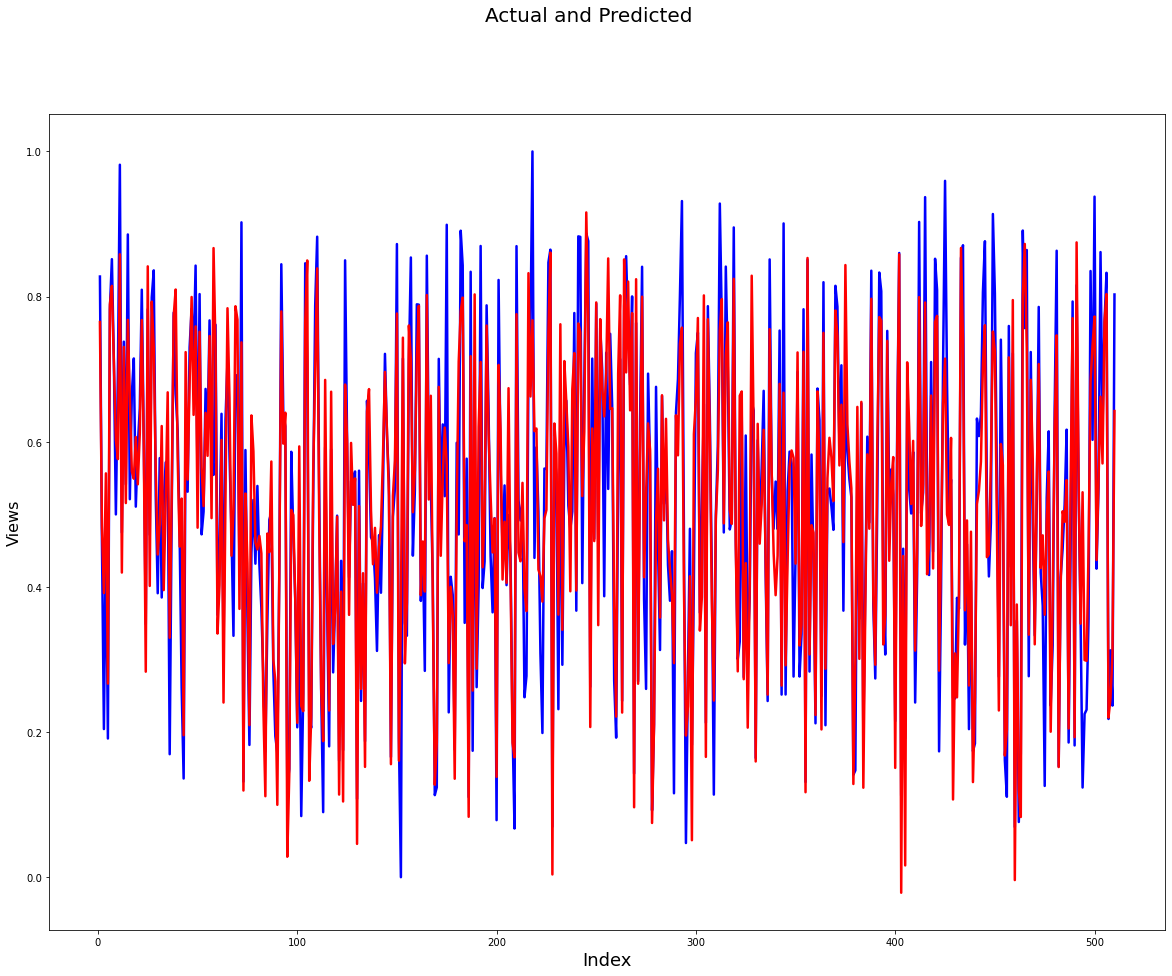

In [322]:
#Actual vs Predicted
c = [i for i in range(1,511,1)]
fig = plt.figure(figsize=[20,15])
plt.plot(c,y_train, color="blue", linewidth=2.5, linestyle="-")
plt.plot(c,y_train_predict, color="red",  linewidth=2.5, linestyle="-")
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Views', fontsize=16)

From the above graph, predicted values are override with actual views, this shows that our prediction is going in correct way

###  Model Validation

##### Validating the assumption of Linear Regression Model :

`Linear Relationship`
`Homoscedasticity`
`Absence of Multicollinearity`
`Independence of residuals`
`Normality of Errors`

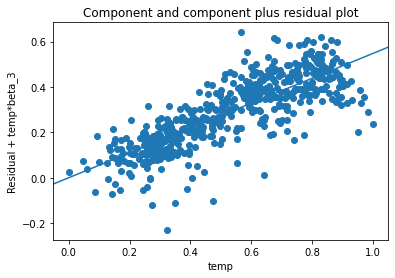

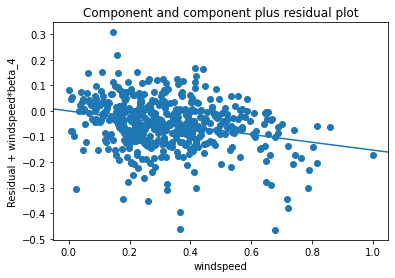

In [323]:
# linear relationship check:
sm.graphics.plot_ccpr(lm7, 'temp')
plt.show()
sm.graphics.plot_ccpr(lm7, 'windspeed')
plt.show()


Insight: The graph shows that linearity is preserved between the model and predictor variables relationship

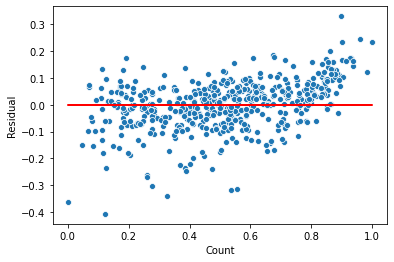

In [324]:
#Homoscedasticity check:
y_train_pred = lm7.predict(x_train_cnst7)
residual = y_train - y_train_pred
sns.scatterplot(y_train, residual)
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('Count')
plt.ylabel('Residual')
plt.show()

Insight : As there is no visible pattern in the graph for residual values, it shows that homoscedasticity is present

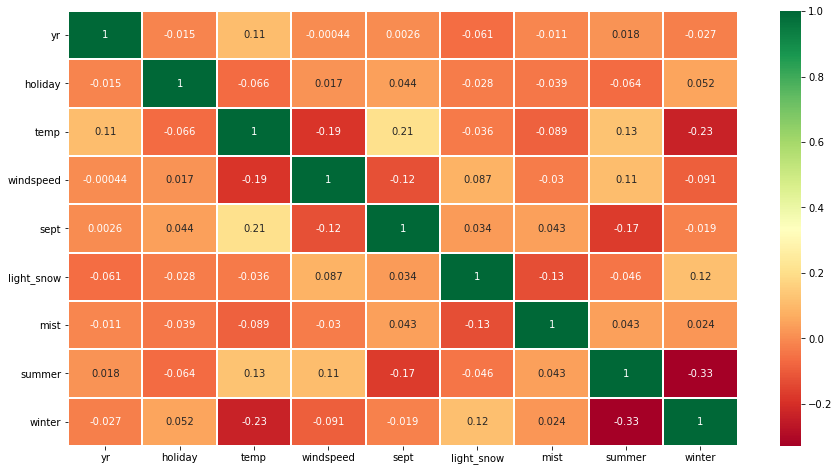

In [325]:
# Absence of Multicolinearity check:

plt.figure(figsize=(15,8))
sns.heatmap(x_train_rfe.corr(),annot = True, cmap="RdYlGn",linewidth =1)
plt.show()

In [326]:
# calculate VIF for the final selected features
calculateVIF(x_train_rfe)

Features   VIF
2        temp  3.68
3   windspeed  3.06
0          yr  2.00
7      summer  1.57
6        mist  1.48
8      winter  1.37
4        sept  1.20
5  light_snow  1.08
1     holiday  1.04

Insight : From the above table, all the features have VIF less than 5. so there is insignificant multicollinearity among them

In [327]:
#Independance fo Residuals:
print ('The Durbin-Watson value for Final Model lm7 is',round(sm.stats.stattools.durbin_watson((y_train - y_train_predict)),4))

The Durbin-Watson value for Final Model lm7 is 2.0967


Insight: The output value shows there is no auto correlation. As value from 0-2 means positive correlation and 2-4 means negative correlation

Text(0.5, 0, 'Errors')

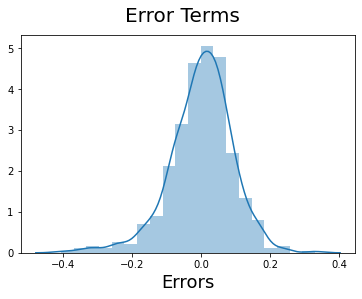

In [328]:
#Normality of error check :

# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_predict), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18) 

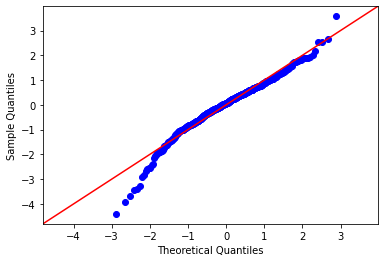

In [329]:
# check using q-q plot
sm.qqplot((y_train - y_train_predict), fit=True, line='45')
plt.show()

Insight : From the above two graphs, it is clear that errors are normally distributed

### Making Predictions for test dataset using model lm7

In [330]:
## First, we will scale the columns of df_test dataset as same as we did for training dataset
df_test.head()

yr  holiday  workingday       temp      hum  windspeed   cnt  aug  dec  \
184   0        1           0  29.793347  63.7917   5.459106  6043    0    0   
535   1        0           1  32.082500  59.2083   7.625404  6211    0    0   
299   0        0           1  19.270000  81.2917  13.250121  2659    0    0   
221   0        0           1  31.433347  42.4167  13.417286  4780    1    0   
152   0        0           1  29.315000  30.5000  19.583229  4968    0    0   

     feb  ...  satur  sun  thurs  tues  wednes  light_snow  mist  spring  \
184    0  ...      0    0      0     0       1           0     1       0   
535    0  ...      0    0      0     0       0           0     0       0   
299    0  ...      1    0      0     0       0           0     1       0   
221    0  ...      0    0      0     0       0           0     0       0   
152    0  ...      1    0      0     0       0           0     0       0   

     summer  winter  
184       0       0  
535       1       0  
299       0       1  
221       0       0  
152       1       0  

[5 rows x 29 columns]

In [331]:
# create list of columns required for scaling
scaling_var_test = ['temp','hum','windspeed','cnt']
df_test[scaling_var_test]= scaler.transform(df_test[scaling_var_test])

In [332]:
# Divide the dataset into dependent and independent variables
y_test = df_test.pop('cnt')
x_test = df_test

In [333]:
# Creating x_test with only features used in training dataset
x_test = x_test[x_train_rfe.columns]

# Adding a constant variable and manual run model on test data
x_test_cnst = sm.add_constant(x_test)

In [340]:
y_pred = lm7.predict (x_test_cnst)

Text(0, 0.5, 'y_pred')

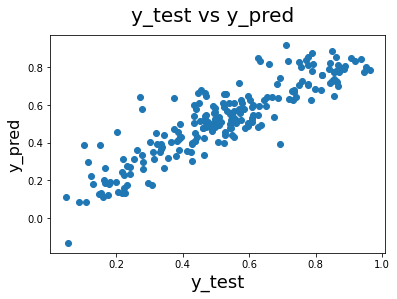

In [341]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_predict)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16) 

It shows that y_test and y_pred are followed a linear pattern

###### R2_score calculation for bike test dataset

In [342]:
from sklearn.metrics import r2_score
r2 = round(r2_score(y_test, y_pred),4)
r2

0.7942

###### Adjusted R2 Value Calculation using formula 1-(1-r2)*(n-1)/(n-p-1): 

In [343]:
# n is number of rows in test dataset
n = x_test.shape[0]

# Number of features (predictors, p) is the shape along axis 1
p = x_test.shape[1]

# We find the Adjusted R-squared using the formula
adjusted_r2 = round(1-(1-r2)*(n-1)/(n-p-1),4)
adjusted_r2

0.7854

###### Calculating RMSE for the selected Model

In [338]:
RMSE = round(sqrt(mean_squared_error(y_test, y_test_predict)),4)
RMSE

0.0992

###### Calculating Mean Absolute Error for the selected Model

In [339]:
MAE = round(mean_absolute_error(y_test, y_test_predict),4)
MAE

0.0758

### According to all the above calculations, we can conclude that our model is pretty good to go.